Copyright (C) 2019 Willy Po-Wei Wu <maya6282@gmail.com> and Elvis Yu-Jing Lin <elvisyjlin@gmail.com>

This work is licensed under the Creative Commons Attribution-NonCommercial
4.0 International License. To view a copy of this license, visit
http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

#### Some Abbreviations
1. cm: confusion matrix
2. rp: classification report
3. fi: feature importance
4. if: important features

In [1]:
# Import all used packages

import argparse
import collections
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.utils import class_weight

from tqdm import tqdm

from learn import get_model, get_params
from utils import run_from_ipython, np2df
from viz import show_cm_list, show_rp_list

if run_from_ipython():
    import matplotlib
    %matplotlib inline
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_context('notebook')  # 'notebook', 'paper', 'talk', 'poster'
    # sns.set_style('dark')  # None, 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'

In [2]:
# Parse Arguments

def parse(args=None):
    parser = argparse.ArgumentParser(
        prog='Classification',
        description='Train and test a machine learning classification method on the extracted features.'
    )
    parser.add_argument('--n_folds', help='n folds cross validation', type=int, default=10)
    parser.add_argument('--feature_type', '-f',
                        help='feature type ("b" | "e" | "m" or "if4", "if5", "if10", "if13", "if20", "if64")',
                        type=str, default='bem')
    parser.add_argument('--scheme', '-s', help='data scheme', type=str,
                        choices=['address', 'entity'], default='address')
    parser.add_argument('--gpu', help='use GPU', action='store_true')
    parser.add_argument('--output', '-o', help='output path', type=str, default='./data_p')
    parser.add_argument('--result', '-r', help='result path', type=str, default='./result')
    parser.add_argument('--temp', '-t', help='temp path', type=str, default='./temp')
    return parser.parse_args() if args is None else parser.parse_args(args)
args = parse([]) if run_from_ipython() else parse()
print(args)

Namespace(feature_type='bem', gpu=False, n_folds=10, output='./data_p', result='./result', scheme='address', temp='./temp')


In [3]:
# Define the experiment setting

n_folds = args.n_folds                       # 10
feature_type = args.feature_type             # 'b' | 'e' | 'm' or 'if4', 'if5', 'if10', 'if13', 'if20', 'if64'
scheme = args.scheme                         # 'address', 'entity'
gpu = args.gpu
output_path = args.output
result_path = args.result
temp_path = args.temp

# Check the experiment setting

assert not feature_type.startswith('if') and len(feature_type) > 0 or \
       feature_type.startswith('if') and feature_type[2:].isdigit()
assert scheme in ['address', 'entity']

# Number of epochs to train
# The specified epochs are enough to converge for each scheme
if scheme == 'address':
    epochs = 4000
elif scheme == 'entity':
    epochs = 1500

# Show the experiment setting

print('Experiment Setting')
print('===> Feature Types:  ', feature_type)
print('===> Data Scheme:    ', scheme)
print('===> Use GPU:        ', gpu)
print('===> Training epochs:', epochs)

Experiment Setting
===> Feature Types:   bem
===> Data Scheme:     address
===> Use GPU:         False
===> Training epochs: 4000


In [4]:
# 定義一個函數來加載和抽樣數據
def load_sample(file_path, sample_fraction=0.1):
    chunks = []
    for chunk in pd.read_csv(file_path, chunksize=100000):
        chunks.append(chunk.sample(frac=sample_fraction))
    return pd.concat(chunks)

In [5]:
# Load transaction history summarization data

# 設定樣本比例
sample_fraction = 0.04  # 取 0.4% 的數據樣本

# data_file = 'data.{}.csv'.format(scheme)
data_file = 'nanzero_normalization_data.{}.csv'.format(scheme)
# data_file = 'quantum_qubo_data.{}.csv'.format(scheme)
# data_file = 'all_selected_features_quantum_qubo_data.{}.csv'.format(scheme)
file_path = os.path.join(output_path, data_file)
data = load_sample(file_path, sample_fraction)
# data = pd.read_csv(os.path.join(output_path, data_file))
print (data)
if run_from_ipython():
    data.head(4)
else:
    print(data.head(4))

             n_tx  total_days  total_spent_btc  total_received_btc  \
7357    -0.180649   -0.400931        -0.018526           -0.018526   
57861   -0.101101   -0.344737        -0.020821           -0.020821   
58777   -0.180649   -0.400931         0.039418            0.039418   
57262   -0.180649   -0.400931        -0.020564           -0.020564   
67274   -0.180649   -0.400931        -0.013608           -0.013608   
...           ...         ...              ...                 ...   
1812707  0.137544   -0.279178        -0.017362           -0.017362   
1848411 -0.180649   -0.400931        -0.019432           -0.019432   
1803044 -0.180649   -0.400931        -0.017822           -0.017822   
1833321 -0.180649   -0.400931        -0.019151           -0.019151   
1831400 -0.101101   -0.400931        -0.015952           -0.015952   

         total_spent_usd  total_received_usd  mean_balance_btc  \
7357           -0.013056           -0.013056         -0.034238   
57861          -0.012698   

In [6]:
# Define 4 types of features (basic statistics, extra statistics, moments and patterns)

basic = [
    'f_tx', 'f_received', 'f_coinbase',
    'f_spent_digits_-3', 'f_spent_digits_-2', 'f_spent_digits_-1', 'f_spent_digits_0',
    'f_spent_digits_1', 'f_spent_digits_2', 'f_spent_digits_3', 'f_spent_digits_4',
    'f_spent_digits_5', 'f_spent_digits_6', 'f_received_digits_-3', 'f_received_digits_-2',
    'f_received_digits_-1', 'f_received_digits_0', 'f_received_digits_1', 'f_received_digits_2',
    'f_received_digits_3', 'f_received_digits_4', 'f_received_digits_5', 'f_received_digits_6',
    'r_payback', 'n_inputs_in_spent', 'n_outputs_in_spent'
]
extra = [
    'n_tx', 'total_days', 'n_spent', 'n_received', 'n_coinbase', 'n_payback',
    'total_spent_btc', 'total_received_btc',
    'total_spent_usd', 'total_received_usd',
    'mean_balance_btc', 'std_balance_btc',
    'mean_balance_usd', 'std_balance_usd'
]
moments = [
    'interval_1st_moment', 'interval_2nd_moment', 'interval_3rd_moment', 'interval_4th_moment',
    'dist_total_1st_moment', 'dist_total_2nd_moment', 'dist_total_3rd_moment', 'dist_total_4th_moment',
    'dist_coinbase_1st_moment', 'dist_coinbase_2nd_moment', 'dist_coinbase_3rd_moment', 'dist_coinbase_4th_moment',
    'dist_spend_1st_moment', 'dist_spend_2nd_moment', 'dist_spend_3rd_moment', 'dist_spend_4th_moment',
    'dist_receive_1st_moment', 'dist_receive_2nd_moment', 'dist_receive_3rd_moment', 'dist_receive_4th_moment',
    'dist_payback_1st_moment', 'dist_payback_2nd_moment', 'dist_payback_3rd_moment', 'dist_payback_4th_moment'
]
patterns =[
    'tx_input', 'tx_output',
    'n_multi_in', 'n_multi_out', 'n_multi_in_out'
]

features = []
if not feature_type.startswith('if') and len(feature_type) > 0:
    if 'b' in feature_type:
        features += basic
    if 'e' in feature_type:
        features += extra
    if 'm' in feature_type:
        features += moments
    if 'p' in feature_type:
        features += patterns
        print("Patterns included:", patterns)
elif feature_type.startswith('if') and feature_type[2:].isdigit():
    """
    Important features from LightGBM with BEM
    [ 0 25 24 29 40 37 27 23 56 36  1 28 26 57 32 38 44 45 33 18 39 60 53 35
     34 52 41 17 14 15 16 19 42  5  6 47  7 46  2 54  4 43  8 59 58 55  9 13
     61 48  3 31 10 62 20 21 63 30 49 11 51 50 22 12]
    """
    all_features = basic + extra + moments + patterns
    if_indices = [
        0, 25, 24, 29, 40, 37, 27, 23, 56, 36,
        1, 28, 26, 57, 32, 38, 44, 45, 33, 18,
        39, 60, 53, 35, 34, 52, 41, 17, 14, 15,
        16, 19, 42, 5, 6, 47, 7, 46, 2, 54,
        4, 43, 8, 59, 58, 55, 9, 13, 61, 48,
        3, 31, 10, 62, 20, 21, 63, 30, 49, 11,
        51, 50, 22, 12
    ]
    if_features = [all_features[i] for i in if_indices]
    n_if = int(feature_type[2:])
    features = if_features[:n_if]
else:
    raise Exception('Invalid feature types: {:s}'.format(feature_type))

invalid_features = [feature for feature in features if feature not in data.columns]
assert len(invalid_features) == 0, 'Invalid features: ' + ', '.join(invalid_features)

X = data.get(features).values
y = data['class'].values
print (features)
print (feature_type)
print (X)
print (y)

class2label = json.loads(open(os.path.join(output_path, 'class2label.json'), 'r').read())
label2class = json.loads(open(os.path.join(output_path, 'label2class.json'), 'r').read())
class_names = np.array([label2class[i] for i in range(6)])
print (class_names)
y_names = class_names
# y_names = class_names[y]
# y_names = np.array(class_names)[y.astype(int)]

print(len(X), len(y), len(features))

os.makedirs(result_path, exist_ok=True)

['f_tx', 'f_received', 'f_coinbase', 'f_spent_digits_-3', 'f_spent_digits_-2', 'f_spent_digits_-1', 'f_spent_digits_0', 'f_spent_digits_1', 'f_spent_digits_2', 'f_spent_digits_3', 'f_spent_digits_4', 'f_spent_digits_5', 'f_spent_digits_6', 'f_received_digits_-3', 'f_received_digits_-2', 'f_received_digits_-1', 'f_received_digits_0', 'f_received_digits_1', 'f_received_digits_2', 'f_received_digits_3', 'f_received_digits_4', 'f_received_digits_5', 'f_received_digits_6', 'r_payback', 'n_inputs_in_spent', 'n_outputs_in_spent', 'n_tx', 'total_days', 'n_spent', 'n_received', 'n_coinbase', 'n_payback', 'total_spent_btc', 'total_received_btc', 'total_spent_usd', 'total_received_usd', 'mean_balance_btc', 'std_balance_btc', 'mean_balance_usd', 'std_balance_usd', 'interval_1st_moment', 'interval_2nd_moment', 'interval_3rd_moment', 'interval_4th_moment', 'dist_total_1st_moment', 'dist_total_2nd_moment', 'dist_total_3rd_moment', 'dist_total_4th_moment', 'dist_coinbase_1st_moment', 'dist_coinbase_2n

In [ ]:
# def data_distribution(df):
#     if run_from_ipython():
#         plt.figure()
#         sns.countplot(df.index)
#     cnt = collections.Counter(df.index)
#     print(cnt)
#     return np.array([cnt[i] for i in range(len(cnt))])

# print(class2label)
# y_count = data_distribution(np2df(X, y))

In [7]:
import os
import pickle
import shutil
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model

# 如果不想使用 GPU，可以設置環境變量
if not gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# GPU 配置 for TensorFlow 2.x
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 為每個 GPU 設置允許記憶體增長
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

def build_model(input_size, num_classes, summary=False):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_size,)),
        BatchNormalization(momentum=0.0, epsilon=1e-5),
        # Dropout(0.2),
        # Dense(512, activation='relu'),
        # BatchNormalization(momentum=0.0, epsilon=1e-5),
        # Dropout(0.2),
        # Dense(512, activation='relu'),
        # BatchNormalization(momentum=0.0, epsilon=1e-5),
        Dropout(0.2),
        Dense(512, activation='relu'),
        BatchNormalization(momentum=0.0, epsilon=1e-5),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    if summary:
        model.summary()
    return model


In [8]:
import time
import numpy as np
import os
import shutil
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from keras.models import load_model
import keras

# 加入時間模組

# 訓練過程
train_cm_list = []
train_rp_list = []
valid_cm_list = []
valid_rp_list = []
fi_list = []

# Add these lists to store AUC scores
train_auc_list = []
valid_auc_list = []

# 宣告 K-Fold
n_folds = 10
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# # 標準化資料
# print('Normalizing data...')
# X = np.nan_to_num((X - np.mean(X, axis=0)) / np.std(X, axis=0))
# X = np.clip(X, np.percentile(X, 1, axis=0), np.percentile(X, 99, axis=0))

# 開始計算整體訓練時間
total_start_time = time.time()  # 全部訓練開始時間

# 開始交叉驗證
for i, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    # 取得分割的訓練集和驗證集
    X_train, X_valid = X[train_idx], X[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]
    y_train_ = keras.utils.to_categorical(y_train, num_classes=len(class2label))
    y_valid_ = keras.utils.to_categorical(y_valid, num_classes=len(class2label))
    
    # 建立模型
    model = build_model(X.shape[1], len(label2class), summary=(i==0))
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.999),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # 訓練模型
    acc = -1
    for epoch in range(epochs):
        model.train_on_batch(X_train, y_train_)
        accs = model.test_on_batch(X_valid, y_valid_)
        if accs[1] > acc:
            acc = accs[1]
            print(acc, epoch)
            model.save(os.path.join(temp_path, 'model.h5'))
    model = load_model(os.path.join(temp_path, 'model.h5'))
    
    # 在訓練集上評估
    y_pred = np.argmax(model.predict(X_train), axis=1)
    cm = confusion_matrix(y_train, y_pred)
    cm_sum = cm.sum(axis=1, keepdims=True)
    cm_sum[cm_sum == 0] = 1  # 防止除零
    cm = cm / cm_sum
    train_cm_list.append(cm)
    
    # 在驗證集上評估
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    cm = confusion_matrix(y_valid, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    valid_cm_list.append(cm)
    rp = classification_report(y_valid, y_pred, target_names=class_names, output_dict=True)
    valid_rp_list.append(rp)
    
    # Calculate AUC for the training set
    y_train_prob = model.predict(X_train)
    train_auc = roc_auc_score(y_train, y_train_prob, multi_class="ovr", average="macro")
    train_auc_list.append(train_auc)

    # Calculate AUC for the validation set
    y_valid_prob = model.predict(X_valid)
    valid_auc = roc_auc_score(y_valid, y_valid_prob, multi_class="ovr", average="macro")
    valid_auc_list.append(valid_auc)

# 全部訓練結束時間
total_end_time = time.time()
total_training_time = total_end_time - total_start_time  # 計算總訓練時間
print(f"Total training time: {total_training_time:.2f} seconds")  # 輸出總訓練時間

# 清除臨時檔案
shutil.rmtree(temp_path)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               33280     
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


0.35808035731315613 1
0.3970519006252289 2
0.4207444190979004 3
0.42525407671928406 4
0.45789864659309387 5
0.460052490234375 6
0.47055259346961975 7
0.48199501633644104 8
0.4831392467021942 11
0.4877835512161255 13
0.4879181385040283 15
0.4886585474014282 16
0.4959951639175415 21
0.4966682493686676 22
0.5009086728096008 28
0.5012452006340027 32
0.5359089970588684 33
0.5403513312339783 38
0.5404186844825745 49
0.5429090857505798 57
0.5519284009933472 63
0.5545533895492554 65
0.5633034706115723 68
0.5682169795036316 69
0.5703708529472351 78
0.698391318321228 84
0.7001413702964783 93
0.7090933322906494 97
0.7091606855392456 109
0.7162953615188599 113
0.7225550413131714 116
0.7233627438545227 123
0.7248435020446777 130
0.7257184982299805 135
0.7260550856590271 136
0.726593554019928 143
0.7281416058540344 146
0.7286127805709839 147
0.7293531894683838 150
0.7297570109367371 157
0.7300935387611389 161
0.7309012413024902 164
0.7311704754829407 166
0.7327858805656433 169
0.7334589958190918 177

C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

465/465 [==============================] - 0s 814us/step
0.2334410399198532 0


C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


0.31219708919525146 1
0.34854602813720703 2
0.38206785917282104 3
0.41855141520500183 4
0.42703285813331604 5
0.44702476263046265 7
0.45220786333084106 8
0.465131938457489 10
0.46943995356559753 13
0.47024771571159363 14
0.47724825143814087 16
0.4773155748844147 17
0.48209476470947266 19
0.5156165957450867 20
0.5293484330177307 25
0.5493403077125549 79
0.6367124319076538 84
0.6988422274589539 89
0.7046311497688293 92
0.7061120271682739 93
0.712977945804596 96
0.7198438048362732 105
0.7243537902832031 112
0.7249596118927002 114
0.7269790172576904 123
0.7276521325111389 135
0.7277867794036865 136
0.7278540730476379 140
0.728056013584137 142
0.729604184627533 144
0.73021000623703 152
0.7315562963485718 163
0.7324986457824707 165
0.7335083484649658 168
0.735123872756958 170
0.7372778654098511 176
0.7376817464828491 181
0.7377490401268005 182
0.7379509806632996 187
0.7390279769897461 198
0.7409800887107849 199
0.741383969783783 200
0.7422590255737305 202
0.7441437840461731 205
0.74454766511

C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


0.361470103263855 1
0.42777329683303833 2
0.43450456857681274 3
0.4508616030216217 4
0.4523424804210663 5
0.4684302508831024 6
0.46970921754837036 7
0.4775848090648651 8
0.48115238547325134 9
0.48371028900146484 10
0.4876817464828491 13
0.4882875680923462 14
0.48963382840156555 15
0.4898357689380646 18
0.4932014048099518 19
0.493537962436676 23
0.49468228220939636 24
0.4960285425186157 28
0.4960958659648895 33
0.49690359830856323 35
0.4976440370082855 36
0.4991922378540039 39
0.4997307360172272 40
0.5010097026824951 41
0.5014135837554932 43
0.5191841721534729 45
0.5411954522132874 46
0.6864566802978516 74
0.6894857287406921 77
0.7136510610580444 85
0.7176898121833801 89
0.7186322212219238 97
0.7207862138748169 103
0.7214593291282654 106
0.7227382659912109 108
0.7230748534202576 112
0.7240845561027527 116
0.7248923182487488 119
0.7257673740386963 123
0.7267097234725952 131
0.7278540730476379 133
0.7289310693740845 141
0.7295368909835815 142
0.7322294116020203 148
0.7326332926750183 153


C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


0.22273828089237213 1
0.38644319772720337 2
0.4242730140686035 3
0.43874529004096985 4
0.44554388523101807 5
0.4507942795753479 6
0.45644858479499817 7
0.46122777462005615 8
0.46540117263793945 9
0.47044965624809265 10
0.471795916557312 11
0.47630587220191956 12
0.4773828685283661 13
0.47973883152008057 14
0.4799407720565796 15
0.4816235899925232 16
0.48552772402763367 18
0.48633548617362976 22
0.48889338970184326 23
0.49131664633750916 25
0.4923263192176819 27
0.49279752373695374 28
0.4934033453464508 29
0.4950188398361206 30
0.4959612190723419 31
0.49885568022727966 33
0.4993268847465515 36
0.4999326765537262 37
0.5014135837554932 38
0.5023559331893921 39
0.5028271675109863 42
0.5073370933532715 44
0.5075390338897705 47
0.50801020860672 48
0.5108373761177063 49
0.5129913687705994 52
0.5132606625556946 54
0.5166262984275818 56
0.5214728116989136 57
0.5232902765274048 59
0.5302234888076782 60
0.5385702848434448 63
0.5669090151786804 64
0.5723613500595093 69
0.6609450578689575 71
0.6714

C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


0.3073505759239197 1
0.361672043800354 2
0.3851642310619354 3
0.4089256823062897 4
0.4250807762145996 5
0.42615777254104614 7
0.4334275722503662 8
0.4351103901863098 9
0.4408993124961853 10
0.4433225691318512 11
0.44864028692245483 12
0.4597468972206116 13
0.4708535373210907 16
0.4724690318107605 24
0.4766424298286438 26
0.47859451174736023 28
0.4807485044002533 31
0.4816235899925232 33
0.5154146552085876 34
0.5167608857154846 53
0.5423398017883301 64
0.5505519509315491 70
0.5578217506408691 77
0.5757942795753479 80
0.5887183547019958 81
0.6831583380699158 85
0.69514000415802 90
0.708669900894165 98
0.709612250328064 101
0.713179886341095 111
0.7149972915649414 123
0.7232095003128052 126
0.7241518497467041 131
0.7259693145751953 133
0.7265077829360962 140
0.7273155450820923 142
0.7304792404174805 157
0.7316235899925232 161
0.7332391142845154 167
0.7343834042549133 180
0.7346526384353638 182
0.734921932220459 183
0.735325813293457 185
0.7365373969078064 189
0.737075924873352 194
0.73727

In [11]:
import os
import pickle

# 假設 result_path 和其他變數都已經定義

# Create the result path if it does not exist
if not os.path.exists(result_path):
    os.makedirs(result_path)

# Save training results

# 確保 experiment_name 是一個有效的文件名
experiment_name = os.path.join(result_path, '{}.{}.{}'.format('model_name', feature_type, scheme))
# if not cost_sensitive:
#     experiment_name += '.no_cs'
results = {
    'train_cm_list': train_cm_list,
    'valid_cm_list': valid_cm_list,
    'train_rp_list': train_rp_list,
    'valid_rp_list': valid_rp_list,
    'fi_list': fi_list,
    'train_auc_list': train_auc_list,
    'valid_auc_list': valid_auc_list
}
pickle.dump(results, open(experiment_name + '.pkl', 'wb'))

# Save model
model_save_path = '{}_model.h5'.format(experiment_name)
model.save(model_save_path)

print(f"Results and model saved to {result_path}")


Results and model saved to ./result


C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Average confusion matrix of training set in 5-fold


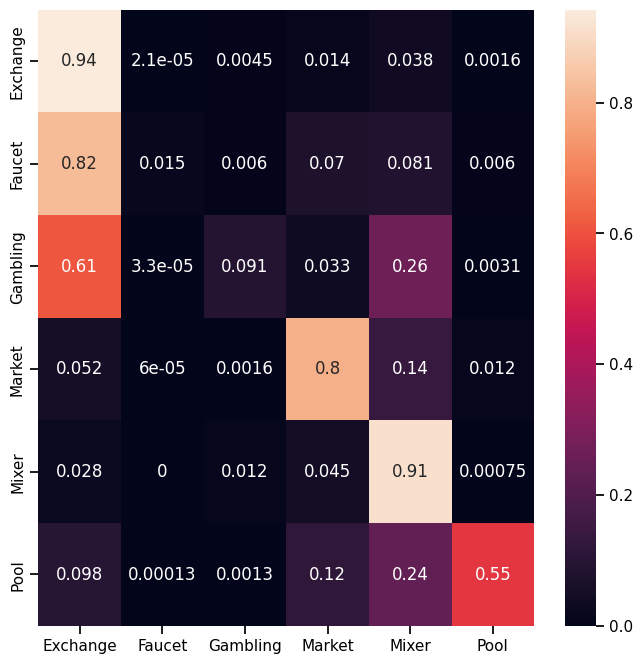

In [84]:
# Average confusion matrix of training set in K-fold

print('Average confusion matrix of training set in {:d}-fold'.format(n_folds))
show_cm_list(train_cm_list, class_names)

In [85]:
def show_rp_list_and_accuracies(rp_list, cm_list, class_names):
    if not rp_list or not cm_list:
        print("The report list or confusion matrix list is empty.")
        return

    summed_metrics = {}
    summed_accuracy = 0
    summed_category_accuracies = {category: 0 for category in class_names}
    category_supports = {category: 0 for category in class_names}

    for report_index, report in enumerate(rp_list):
        for category, metrics in report.items():
            if category == 'accuracy':
                summed_accuracy += metrics
                continue

            if isinstance(metrics, dict) and category in class_names:
                if category not in summed_metrics:
                    summed_metrics[category] = {key: 0 for key in metrics if key != 'support'}
                for metric, value in metrics.items():
                    if metric != 'support':
                        if value > 1:
                            print(f"Debug (initial accumulation): {category} - {metric} has value greater than 1: {value}")
                            value = 1  # 修正异常值
                        summed_metrics[category][metric] += value
                category_supports[category] += metrics.get('support', 0)

        cm = cm_list[report_index]
        for i, category in enumerate(class_names):
            TP = cm[i, i]
            TN = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - TP)
            FP = cm[:, i].sum() - TP
            FN = cm[i, :].sum() - TP
            accuracy = (TP + TN) / float(TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
            summed_category_accuracies[category] += accuracy

    avg_metrics = {}
    total_support = sum(category_supports.values())
    macro_avg = {'precision': 0, 'recall': 0, 'f1-score': 0}
    weighted_avg = {'precision': 0, 'recall': 0, 'f1-score': 0}

    for category, metrics in summed_metrics.items():
        avg_metrics[category] = {metric: value / len(rp_list) for metric, value in metrics.items()}
        for metric in macro_avg:
            macro_avg[metric] += avg_metrics[category][metric] / len(class_names)
            weighted_avg[metric] += (avg_metrics[category][metric] * category_supports[category]) / total_support
            if avg_metrics[category][metric] > 1:
                print(f"Debug (average calculation): {category} - {metric} has value greater than 1: {avg_metrics[category][metric]}")

    avg_accuracy = summed_accuracy / len(rp_list)
    avg_category_accuracies = {category: acc / len(cm_list) for category, acc in summed_category_accuracies.items()}

    print(f"Overall Accuracy: {avg_accuracy:.4f}\n")
    for category, metrics in avg_metrics.items():
        print(f"Category: {category}")
        for metric, value in metrics.items():
            if value > 1:
                print(f"Debug (final report): {category} - {metric} has value greater than 1: {value}")
            print(f"  {metric}: {value:.4f}")
        print(f"  Accuracy: {avg_category_accuracies[category]:.4f}\n")

    print("Category: macro avg")
    for metric, value in macro_avg.items():
        print(f"  {metric}: {value:.4f}")
    print("\nCategory: weighted avg")
    for metric, value in weighted_avg.items():
        print(f"  {metric}: {value:.4f}")

# Assuming n_folds, train_rp_list, train_cm_list, valid_rp_list, valid_cm_list, and class_names are defined elsewhere
print('Average classification report and accuracies of training set in {:d}-fold'.format(n_folds))
show_rp_list_and_accuracies(train_rp_list, train_cm_list, class_names)

print('Average classification report and accuracies of validation set in {:d}-fold'.format(n_folds))
show_rp_list_and_accuracies(valid_rp_list, valid_cm_list, class_names)


Average classification report and accuracies of training set in 5-fold
The report list or confusion matrix list is empty.
Average classification report and accuracies of validation set in 5-fold
Debug (initial accumulation): Exchange - precision has value greater than 1: 5.276380549289497
Debug (initial accumulation): Exchange - recall has value greater than 1: 5.631002527379949
Debug (initial accumulation): Exchange - f1-score has value greater than 1: 5.447904715024875
Debug (initial accumulation): Faucet - precision has value greater than 1: 2.5
Debug (initial accumulation): Gambling - precision has value greater than 1: 3.9061626806890937
Debug (initial accumulation): Gambling - f1-score has value greater than 1: 1.2892290869327503
Debug (initial accumulation): Market - precision has value greater than 1: 3.793457976353732
Debug (initial accumulation): Market - recall has value greater than 1: 5.109465606696994
Debug (initial accumulation): Market - f1-score has value greater than 

Average confusion matrix of validataion set in 5-fold


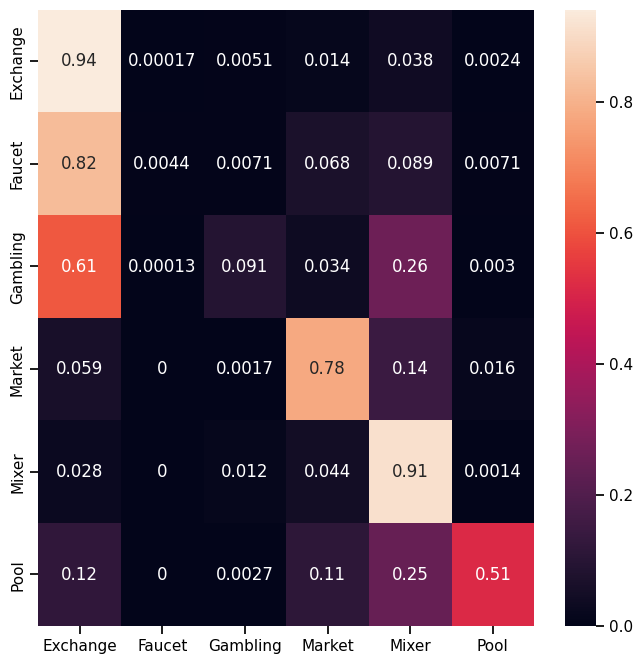

In [86]:
# Average confusion matrix of validataion set in K-fold

print('Average confusion matrix of validataion set in {:d}-fold'.format(n_folds))
show_cm_list(valid_cm_list, class_names)

Average classification report and accuracies of training set in 5-fold
The report list or confusion matrix list is empty.
Average classification report and accuracies of validation set in 5-fold
Debug (initial accumulation): Exchange - precision has value greater than 1: 5.276380549289497
Debug (initial accumulation): Exchange - recall has value greater than 1: 5.631002527379949
Debug (initial accumulation): Exchange - f1-score has value greater than 1: 5.447904715024875
Debug (initial accumulation): Faucet - precision has value greater than 1: 2.5
Debug (initial accumulation): Gambling - precision has value greater than 1: 3.9061626806890937
Debug (initial accumulation): Gambling - f1-score has value greater than 1: 1.2892290869327503
Debug (initial accumulation): Market - precision has value greater than 1: 3.793457976353732
Debug (initial accumulation): Market - recall has value greater than 1: 5.109465606696994
Debug (initial accumulation): Market - f1-score has value greater than 

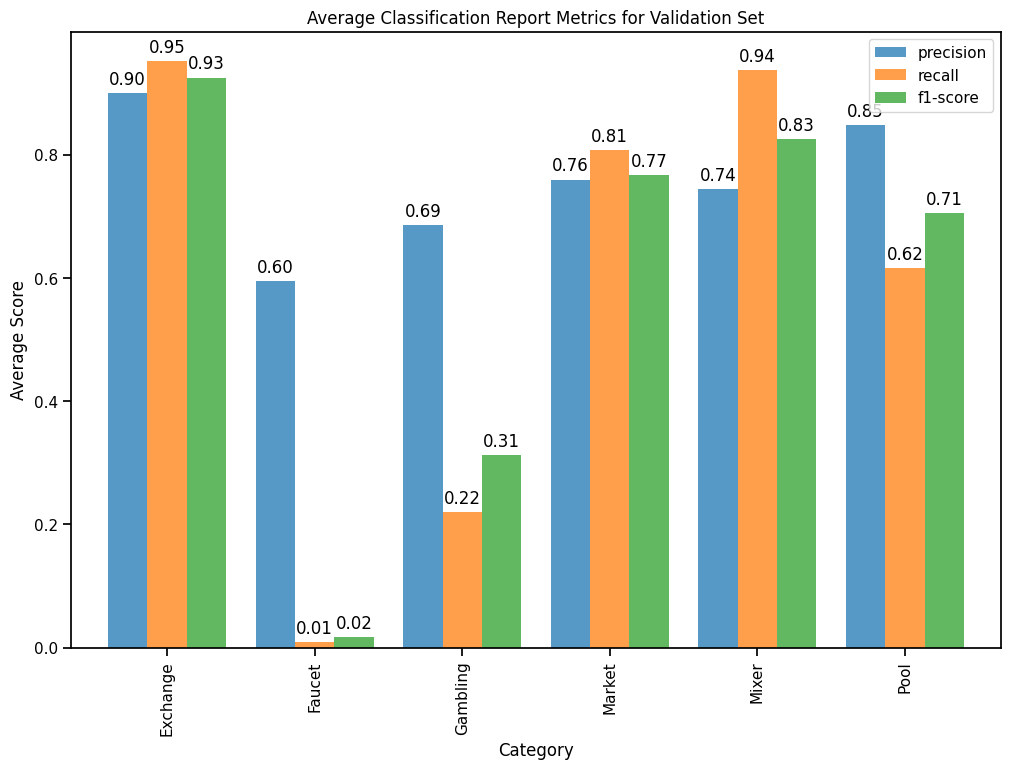

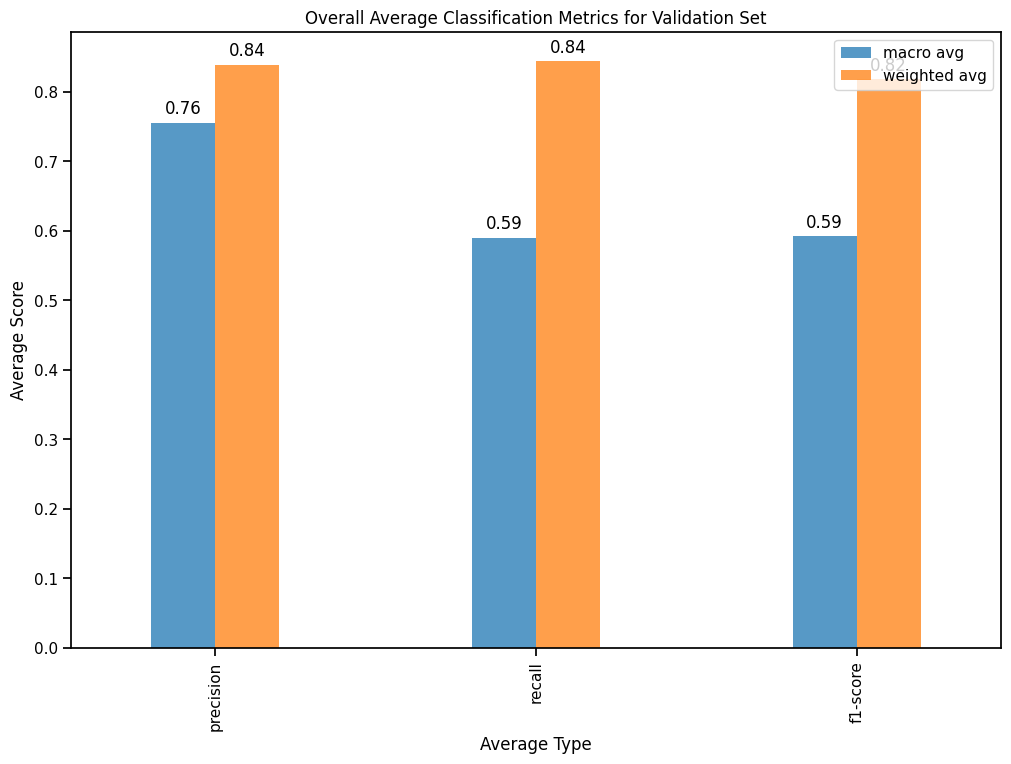

In [98]:
import pandas as pd
import matplotlib.pyplot as plt

def show_rp_list_and_accuracies(rp_list, cm_list, class_names):
    if not rp_list or not cm_list:
        print("The report list or confusion matrix list is empty.")
        return {}, {}, {}

    summed_metrics = {}
    summed_accuracy = 0
    summed_category_accuracies = {category: 0 for category in class_names}
    category_supports = {category: 0 for category in class_names}

    for report_index, report in enumerate(rp_list):
        for category, metrics in report.items():
            if category == 'accuracy':
                summed_accuracy += metrics
                continue

            if isinstance(metrics, dict) and category in class_names:
                if category not in summed_metrics:
                    summed_metrics[category] = {key: 0 for key in metrics if key != 'support'}
                for metric, value in metrics.items():
                    if metric != 'support':
                        if value > 1:
                            print(f"Debug (initial accumulation): {category} - {metric} has value greater than 1: {value}")
                            value = 1  # 修正异常值
                        summed_metrics[category][metric] += value
                category_supports[category] += metrics.get('support', 0)

        cm = cm_list[report_index]
        for i, category in enumerate(class_names):
            TP = cm[i, i]
            TN = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - TP)
            FP = cm[:, i].sum() - TP
            FN = cm[i, :].sum() - TP
            accuracy = (TP + TN) / float(TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
            summed_category_accuracies[category] += accuracy

    avg_metrics = {}
    total_support = sum(category_supports.values())
    macro_avg = {'precision': 0, 'recall': 0, 'f1-score': 0}
    weighted_avg = {'precision': 0, 'recall': 0, 'f1-score': 0}

    for category, metrics in summed_metrics.items():
        avg_metrics[category] = {metric: value / len(rp_list) for metric, value in metrics.items()}
        for metric in macro_avg:
            macro_avg[metric] += avg_metrics[category][metric] / len(class_names)
            weighted_avg[metric] += (avg_metrics[category][metric] * category_supports[category]) / total_support
            if avg_metrics[category][metric] > 1:
                print(f"Debug (average calculation): {category} - {metric} has value greater than 1: {avg_metrics[category][metric]}")

    avg_accuracy = summed_accuracy / len(rp_list)
    avg_category_accuracies = {category: acc / len(cm_list) for category, acc in summed_category_accuracies.items()}

    print(f"Overall Accuracy: {avg_accuracy:.4f}\n")
    for category, metrics in avg_metrics.items():
        print(f"Category: {category}")
        for metric, value in metrics.items():
            if value > 1:
                print(f"Debug (final report): {category} - {metric} has value greater than 1: {value}")
            print(f"  {metric}: {value:.4f}")
        print(f"  Accuracy: {avg_category_accuracies[category]:.4f}\n")

    print("Category: macro avg")
    for metric, value in macro_avg.items():
        print(f"  {metric}: {value:.4f}")
    print("\nCategory: weighted avg")
    for metric, value in weighted_avg.items():
        print(f"  {metric}: {value:.4f}")

    return avg_metrics, macro_avg, weighted_avg

# 假设 n_folds, train_rp_list, train_cm_list, valid_rp_list, valid_cm_list, and class_names are defined elsewhere
print('Average classification report and accuracies of training set in {:d}-fold'.format(n_folds))
train_rp_avg_metrics, train_macro_avg, train_weighted_avg = show_rp_list_and_accuracies(train_rp_list, train_cm_list, class_names)

print('Average classification report and accuracies of validation set in {:d}-fold'.format(n_folds))
valid_rp_avg_metrics, valid_macro_avg, valid_weighted_avg = show_rp_list_and_accuracies(valid_rp_list, valid_cm_list, class_names)

# 繪製平均分類報告指標的柱狀圖
def plot_avg_classification_report(avg_metrics, title):
    df_avg_metrics = pd.DataFrame(avg_metrics).T

    ax = df_avg_metrics.plot(kind='bar', figsize=(12, 8), width=0.8, alpha=0.75)
    ax.set_title(title)
    ax.set_ylabel('Average Score')
    ax.set_xlabel('Category')
    ax.legend(loc='upper right')

    # 在每個柱狀圖上添加數值標籤
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    # 顯示圖表
    plt.show()

# 繪製圖表
plot_avg_classification_report(valid_rp_avg_metrics, 'Average Classification Report Metrics for Validation Set')

# 獨立的程式段，用於繪製包含全部平均分數的表格
def plot_overall_avg_metrics(macro_avg, weighted_avg, title):
    overall_avg_metrics = {
        'macro avg': macro_avg,
        'weighted avg': weighted_avg
    }
    df_overall_avg_metrics = pd.DataFrame(overall_avg_metrics)

    ax = df_overall_avg_metrics.plot(kind='bar', figsize=(12, 8), width=0.4, alpha=0.75)
    ax.set_title(title)
    ax.set_ylabel('Average Score')
    ax.set_xlabel('Average Type')
    ax.legend(loc='upper right')

    # 在每個柱狀圖上添加數值標籤
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    # 顯示圖表
    plt.show()

# 繪製圖表
plot_overall_avg_metrics(valid_macro_avg, valid_weighted_avg, 'Overall Average Classification Metrics for Validation Set')


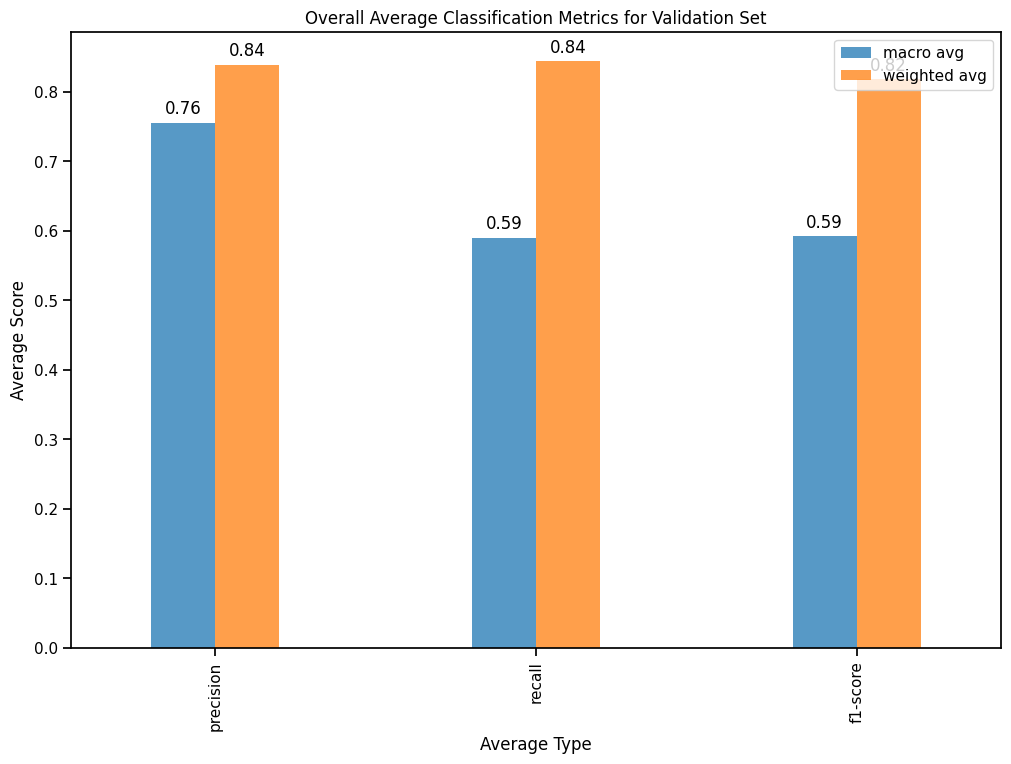

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设 valid_macro_avg 和 valid_weighted_avg 已经定义并包含有效数据
def plot_overall_avg_metrics(macro_avg, weighted_avg, title):
    overall_avg_metrics = {
        'macro avg': macro_avg,
        'weighted avg': weighted_avg
    }
    df_overall_avg_metrics = pd.DataFrame(overall_avg_metrics)

    ax = df_overall_avg_metrics.plot(kind='bar', figsize=(12, 8), width=0.4, alpha=0.75)
    ax.set_title(title)
    ax.set_ylabel('Average Score')
    ax.set_xlabel('Average Type')
    ax.legend(loc='upper right')

    # 在每個柱狀圖上添加數值標籤
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    # 顯示圖表
    plt.show()

# 繪製圖表
plot_overall_avg_metrics(valid_macro_avg, valid_weighted_avg, 'Overall Average Classification Metrics for Validation Set')


Average classification report and accuracies of training set in 5-fold
The report list or confusion matrix list is empty.
Average classification report and accuracies of validation set in 5-fold
Debug (initial accumulation): Exchange - precision has value greater than 1: 5.276380549289497
Debug (initial accumulation): Exchange - recall has value greater than 1: 5.631002527379949
Debug (initial accumulation): Exchange - f1-score has value greater than 1: 5.447904715024875
Debug (initial accumulation): Faucet - precision has value greater than 1: 2.5
Debug (initial accumulation): Gambling - precision has value greater than 1: 3.9061626806890937
Debug (initial accumulation): Gambling - f1-score has value greater than 1: 1.2892290869327503
Debug (initial accumulation): Market - precision has value greater than 1: 3.793457976353732
Debug (initial accumulation): Market - recall has value greater than 1: 5.109465606696994
Debug (initial accumulation): Market - f1-score has value greater than 

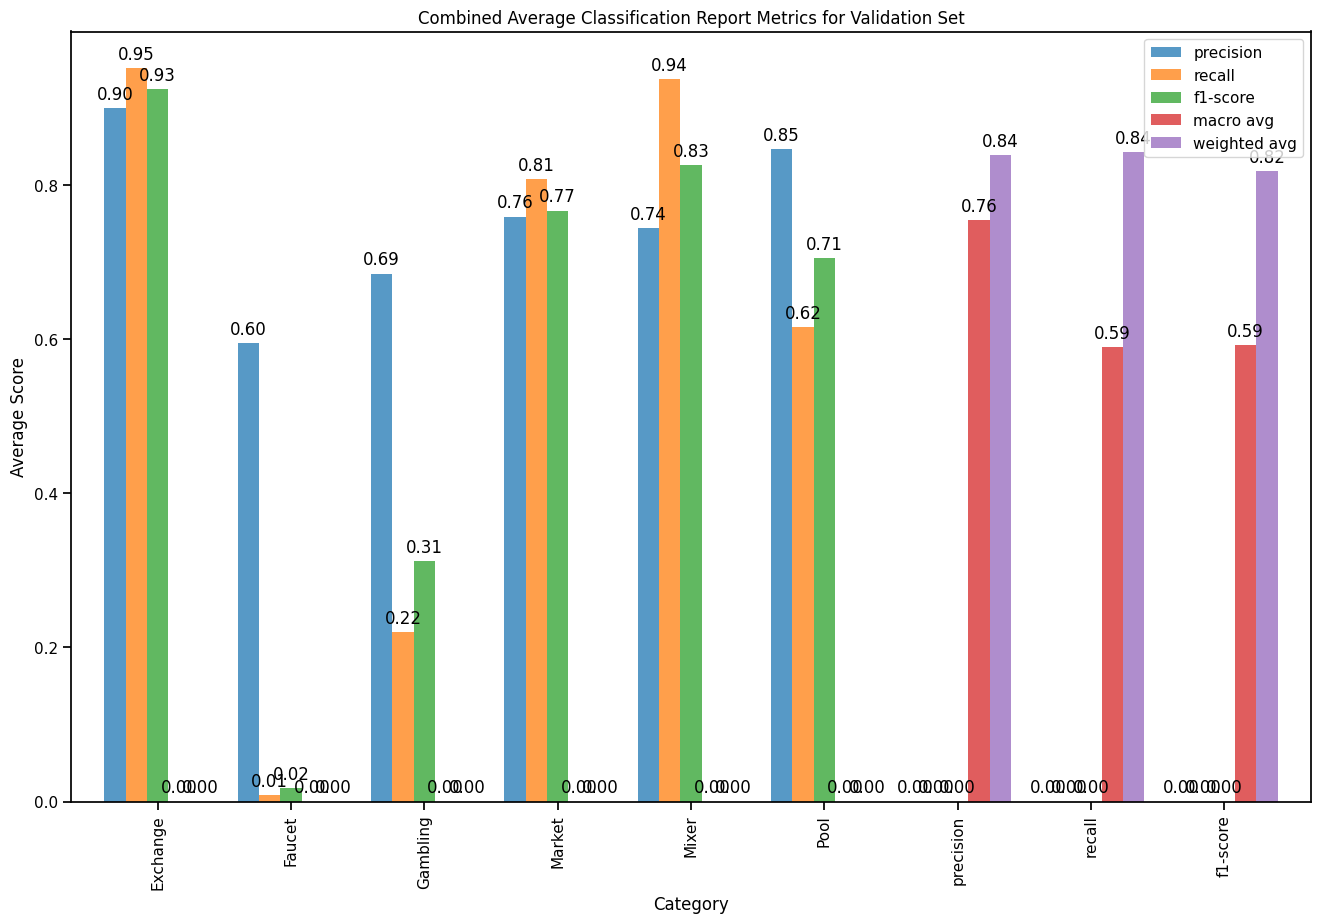

In [99]:
import pandas as pd
import matplotlib.pyplot as plt

def show_rp_list_and_accuracies(rp_list, cm_list, class_names):
    if not rp_list or not cm_list:
        print("The report list or confusion matrix list is empty.")
        return {}, {}, {}

    summed_metrics = {}
    summed_accuracy = 0
    summed_category_accuracies = {category: 0 for category in class_names}
    category_supports = {category: 0 for category in class_names}

    for report_index, report in enumerate(rp_list):
        for category, metrics in report.items():
            if category == 'accuracy':
                summed_accuracy += metrics
                continue

            if isinstance(metrics, dict) and category in class_names:
                if category not in summed_metrics:
                    summed_metrics[category] = {key: 0 for key in metrics if key != 'support'}
                for metric, value in metrics.items():
                    if metric != 'support':
                        if value > 1:
                            print(f"Debug (initial accumulation): {category} - {metric} has value greater than 1: {value}")
                            value = 1  # 修正异常值
                        summed_metrics[category][metric] += value
                category_supports[category] += metrics.get('support', 0)

        cm = cm_list[report_index]
        for i, category in enumerate(class_names):
            TP = cm[i, i]
            TN = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - TP)
            FP = cm[:, i].sum() - TP
            FN = cm[i, :].sum() - TP
            accuracy = (TP + TN) / float(TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
            summed_category_accuracies[category] += accuracy

    avg_metrics = {}
    total_support = sum(category_supports.values())
    macro_avg = {'precision': 0, 'recall': 0, 'f1-score': 0}
    weighted_avg = {'precision': 0, 'recall': 0, 'f1-score': 0}

    for category, metrics in summed_metrics.items():
        avg_metrics[category] = {metric: value / len(rp_list) for metric, value in metrics.items()}
        for metric in macro_avg:
            macro_avg[metric] += avg_metrics[category][metric] / len(class_names)
            weighted_avg[metric] += (avg_metrics[category][metric] * category_supports[category]) / total_support
            if avg_metrics[category][metric] > 1:
                print(f"Debug (average calculation): {category} - {metric} has value greater than 1: {avg_metrics[category][metric]}")

    avg_accuracy = summed_accuracy / len(rp_list)
    avg_category_accuracies = {category: acc / len(cm_list) for category, acc in summed_category_accuracies.items()}

    print(f"Overall Accuracy: {avg_accuracy:.4f}\n")
    for category, metrics in avg_metrics.items():
        print(f"Category: {category}")
        for metric, value in metrics.items():
            if value > 1:
                print(f"Debug (final report): {category} - {metric} has value greater than 1: {value}")
            print(f"  {metric}: {value:.4f}")
        print(f"  Accuracy: {avg_category_accuracies[category]:.4f}\n")

    print("Category: macro avg")
    for metric, value in macro_avg.items():
        print(f"  {metric}: {value:.4f}")
    print("\nCategory: weighted avg")
    for metric, value in weighted_avg.items():
        print(f"  {metric}: {value:.4f}")

    return avg_metrics, macro_avg, weighted_avg

# 假设 n_folds, train_rp_list, train_cm_list, valid_rp_list, valid_cm_list, and class_names are defined elsewhere
print('Average classification report and accuracies of training set in {:d}-fold'.format(n_folds))
train_rp_avg_metrics, train_macro_avg, train_weighted_avg = show_rp_list_and_accuracies(train_rp_list, train_cm_list, class_names)

print('Average classification report and accuracies of validation set in {:d}-fold'.format(n_folds))
valid_rp_avg_metrics, valid_macro_avg, valid_weighted_avg = show_rp_list_and_accuracies(valid_rp_list, valid_cm_list, class_names)

# 繪製包含所有分類報告指標及其宏平均和加權平均值的合併柱狀圖
def plot_combined_avg_classification_report(avg_metrics, macro_avg, weighted_avg, title):
    df_avg_metrics = pd.DataFrame(avg_metrics).T

    # 添加宏平均和加權平均到數據框
    macro_df = pd.DataFrame(macro_avg, index=['macro avg']).T
    weighted_df = pd.DataFrame(weighted_avg, index=['weighted avg']).T
    df_avg_metrics = pd.concat([df_avg_metrics, macro_df, weighted_df], axis=1)

    ax = df_avg_metrics.plot(kind='bar', figsize=(16, 10), width=0.8, alpha=0.75)
    ax.set_title(title)
    ax.set_ylabel('Average Score')
    ax.set_xlabel('Category')
    ax.legend(loc='upper right')

    # 在每個柱狀圖上添加數值標籤
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    # 顯示圖表
    plt.show()

# 繪製合併圖表
plot_combined_avg_classification_report(valid_rp_avg_metrics, valid_macro_avg, valid_weighted_avg, 'Combined Average Classification Report Metrics for Validation Set')


In [ ]:
# Feature Importance

if len(fi_list) == 0:
    exit()
    sys.exit()

try:
    print(clf.importance_type)
except Exception as e:
    print(e)

fi_avg = np.mean(fi_list, axis=0)
# print(fi_avg)
print(fi_avg.argsort()[::-1])
if run_from_ipython():
    df_feature_importances = pd.DataFrame({'name': features, 'importance': fi_avg})
    df_top_10 = df_feature_importances.nlargest(10, columns='importance')
    plt.figure()
    sns.barplot(x='importance', y='name', data=df_top_10)  # Modified this line


In [ ]:
if run_from_ipython():
    plt.figure(figsize=(16, 32))
    for i in range(10):
        feature_index = df_top_10.index[i]
        feature_name = list(df_top_10['name'])[i]
        feature_data = X[:, feature_index]

        # Check if the lengths match
        if len(y_names) != len(feature_data):
            print(f"Length mismatch for feature '{feature_name}': Length of y_names is {len(y_names)}, length of feature data is {len(feature_data)}")
            continue  # Skip this iteration

        plt.subplot(5, 2, i+1)
        plt.title(feature_name)
        ax = sns.boxplot(x=y_names, y=feature_data)


In [100]:
# 平均分類報告
print('Average classification report of validation set in {:d}-fold'.format(n_folds))
valid_rp_avg = compute_avg_classification_report(valid_rp_list)
show_avg_classification_report(valid_rp_avg)

Average classification report of validation set in 5-fold
Debug (average calculation): Exchange - precision has value greater than 1: 1.755152536257628
Debug (average calculation): Exchange - recall has value greater than 1: 1.878281854104031
Debug (average calculation): Exchange - f1-score has value greater than 1: 1.8146134789215822
Debug (average calculation): Gambling - precision has value greater than 1: 1.2667153721121152
Debug (average calculation): Market - precision has value greater than 1: 1.3181760026534695
Debug (average calculation): Market - recall has value greater than 1: 1.6298905634601133
Debug (average calculation): Market - f1-score has value greater than 1: 1.437871863639525
Debug (average calculation): Mixer - precision has value greater than 1: 1.3987182336331125
Debug (average calculation): Mixer - recall has value greater than 1: 1.812314994886178
Debug (average calculation): Mixer - f1-score has value greater than 1: 1.5775562586358987
Debug (average calculat

In [101]:
# Average classification report of validataion set in K-fold

print('Average classification report of validataion set in {:d}-fold'.format(n_folds))
show_rp_list(valid_rp_list)

# 初始化用於存儲每個類別平均精確度、召回率和F1分數的字典
averages = {}

# 遍歷每個報告
for report in valid_rp_list:
    # 遍歷報告中的每個類別
    for category, metrics in report.items():
        # 確保 metrics 是字典類型
        if isinstance(metrics, dict):
            # 如果類別第一次出現，則初始化
            if category not in averages:
                averages[category] = {'precision': 0, 'recall': 0, 'f1-score': 0, 'count': 0}
            
            # 累加該類別的指標值
            for metric in ['precision', 'recall', 'f1-score']:
                averages[category][metric] += metrics.get(metric, 0)
            averages[category]['count'] += 1

# 計算平均值
for category, metrics in averages.items():
    for metric in ['precision', 'recall', 'f1-score']:
        metrics[metric] /= metrics['count']

# 刪除計數鍵
for category in averages:
    del averages[category]['count']

# 轉換成DataFrame
df_averages = pd.DataFrame(averages).T

# 繪製柱狀圖並添加數值標籤
ax = df_averages.plot(kind='bar', figsize=(12, 8), width=0.8, alpha=0.75)
ax.set_title('Average Classification Report Metrics')
ax.set_ylabel('Average Score')
ax.set_xlabel('Category')
ax.legend(loc='upper right')

# 在每個柱狀圖上添加數值標籤
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# 顯示圖表
plt.show()

Average classification report of validataion set in 5-fold


TypeError: 'float' object is not iterable

[0]


C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


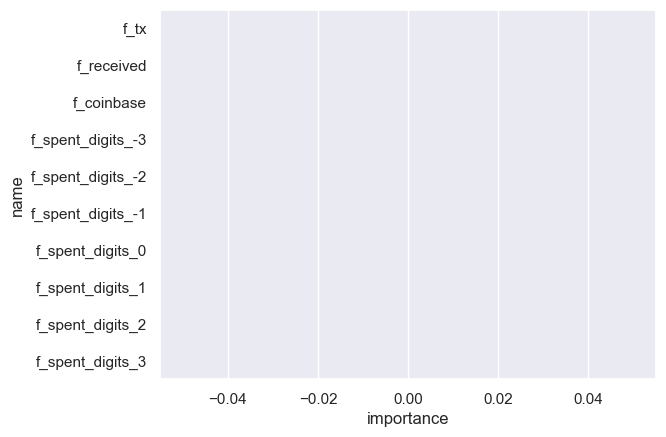

In [106]:
fi_avg = np.mean(fi_list, axis=0)
# print(fi_avg)
print(fi_avg.argsort()[::-1])
if run_from_ipython():
    df_feature_importances = pd.DataFrame({'name': features, 'importance': fi_avg})
    df_least_10 = df_feature_importances.nsmallest(10, columns='importance')
    plt.figure()
    sns.barplot(x='importance', y='name', data=df_least_10)  # Corrected this line


C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\SIEMINGFONG\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[0]


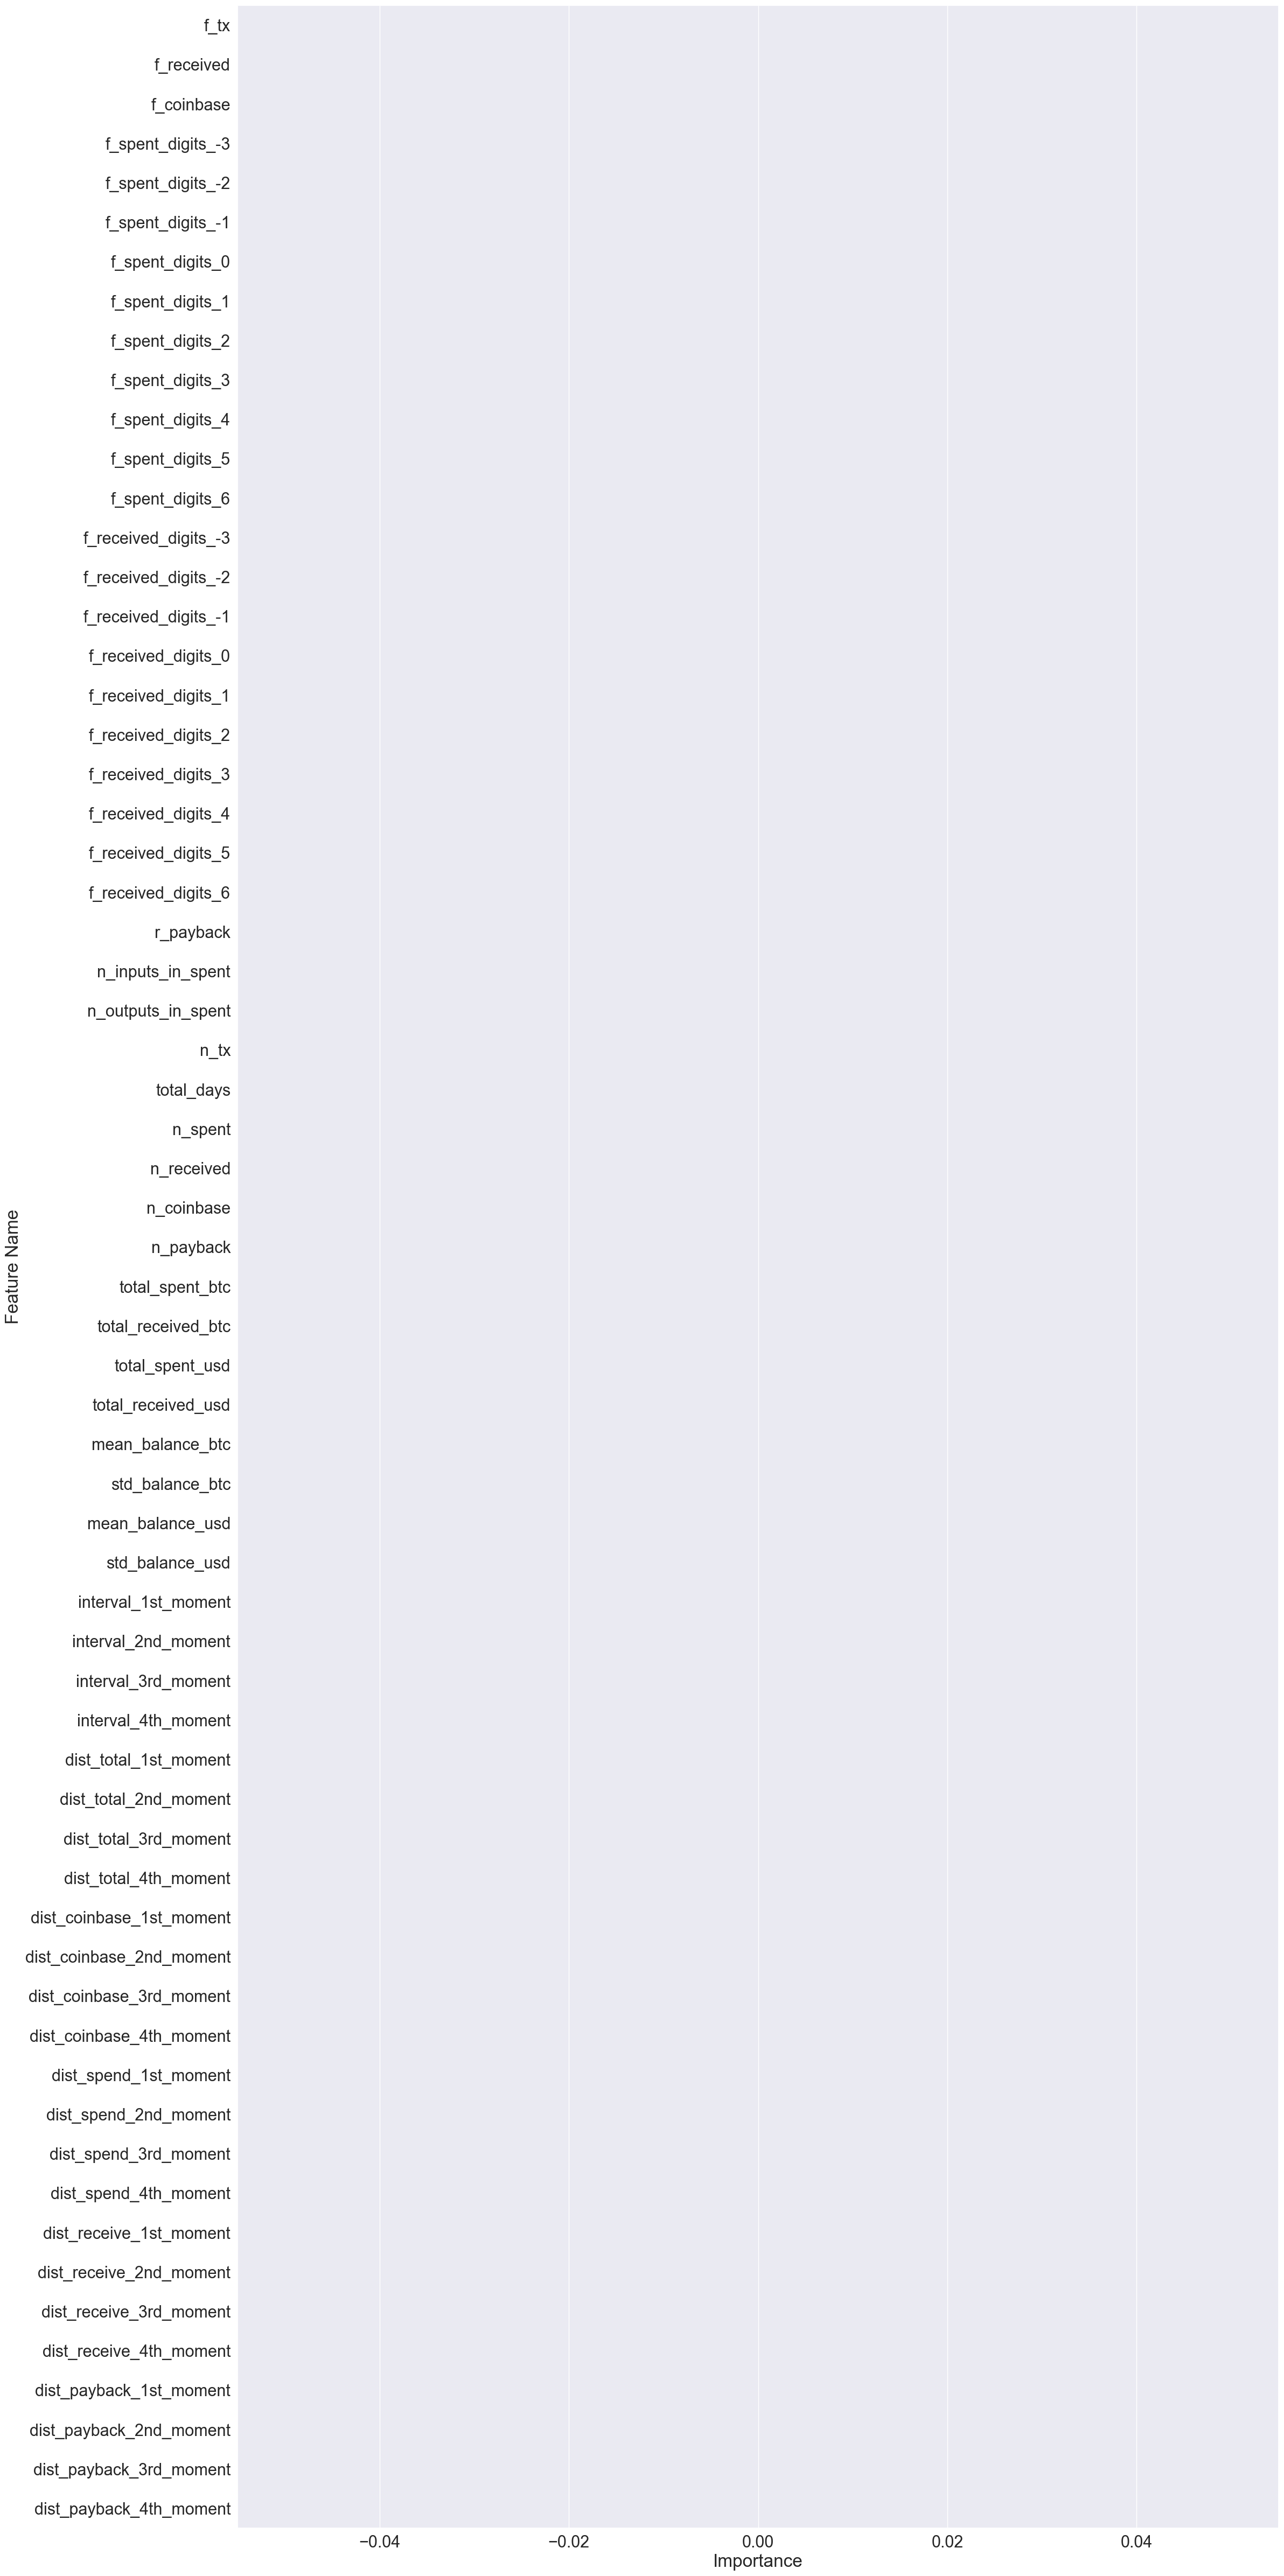

In [105]:
fi_avg = np.mean(fi_list, axis=0)
print(fi_avg.argsort()[::-1])
if run_from_ipython():
    df_feature_importances = pd.DataFrame({'Feature Name': features, 'Importance': fi_avg})
    df_least_10 = df_feature_importances.nlargest(len(features), columns='Importance')
    plt.figure(figsize=(24, 48))
    sns.set(font_scale=2)
    sns.barplot(x='Importance', y='Feature Name', data=df_least_10)  # Corrected this line
    sns.set(font_scale=1)
    plt.tight_layout()
    # plt.savefig('top_10_and_last_10_feature_importance.png')  # Uncomment this line to save the figure


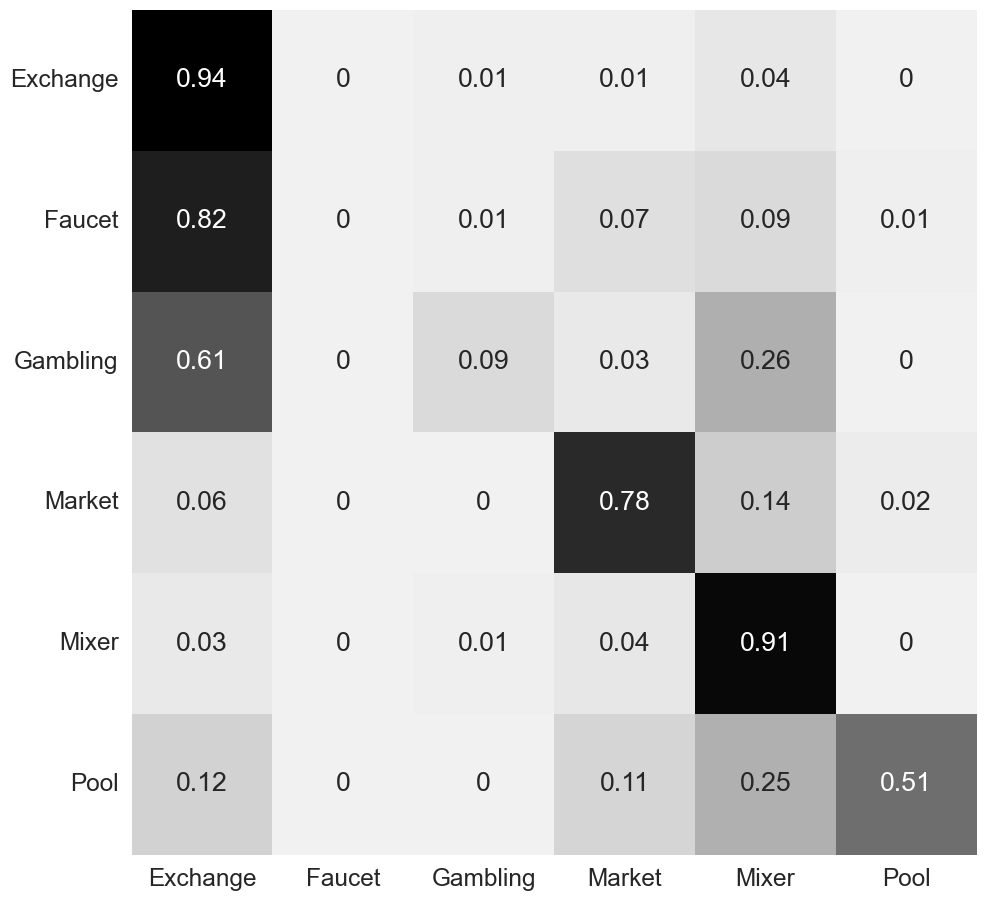

In [104]:
from matplotlib.colors import ListedColormap

cm_avg = np.mean(valid_cm_list, axis=0)
# print(cm_avg)
if run_from_ipython():
    df_cm = pd.DataFrame(cm_avg, index=class_names, columns=class_names)
    plt.figure(figsize=(10, 10))
    # cmap = sns.diverging_palette(220, 10, as_cmap=True)
    cmap = sns.light_palette('black', as_cmap=True)
    # cmap = ListedColormap(['white'])
    sns.set(font_scale=1.6)
    sns.heatmap(df_cm.round(2), annot=True, square=True, cbar=False, cmap=cmap)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    sns.set(font_scale=1)
    plt.tight_layout()
    # plt.savefig('confusion_matrix.png')  # Uncomment this line to save the figure

Average Training Confusion Matrix:
[[9.42108794e-01 2.10627472e-05 4.51273030e-03 1.38067249e-02
  3.79235816e-02 1.62710648e-03]
 [8.21620319e-01 1.53464343e-02 6.00444939e-03 7.00590780e-02
  8.09645285e-02 6.00519095e-03]
 [6.08433942e-01 3.27385824e-05 9.14101367e-02 3.33621431e-02
  2.63683511e-01 3.07752859e-03]
 [5.23392124e-02 6.02954477e-05 1.56777256e-03 7.95951477e-01
  1.38322794e-01 1.17584487e-02]
 [2.77039324e-02 0.00000000e+00 1.18374024e-02 4.53555901e-02
  9.14355452e-01 7.47622580e-04]
 [9.83870968e-02 1.34408602e-04 1.34408602e-03 1.15322581e-01
  2.37634409e-01 5.47177419e-01]]

Average Validation Confusion Matrix:
[[9.40307970e-01 1.68509742e-04 5.05500612e-03 1.36275377e-02
  3.84608846e-02 2.38009142e-03]
 [8.24718254e-01 4.44841270e-03 7.12698413e-03 6.76269841e-02
  8.89563492e-02 7.12301587e-03]
 [6.10136736e-01 1.30975769e-04 9.11420779e-02 3.41777327e-02
  2.61400378e-01 3.01209983e-03]
 [5.88565117e-02 0.00000000e+00 1.68849100e-03 7.79288154e-01
  1.44490

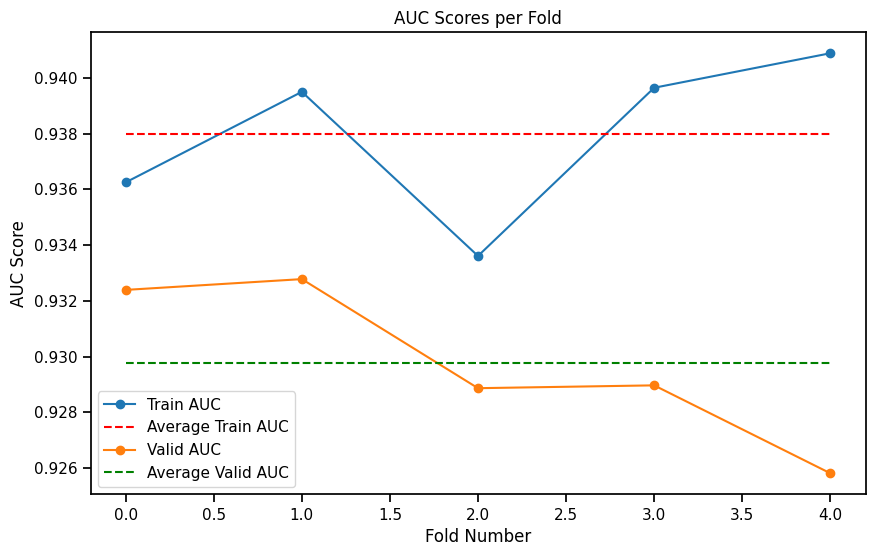

In [102]:
import matplotlib.pyplot as plt

# 计算平均混淆矩阵
avg_train_cm = np.mean(train_cm_list, axis=0)
avg_valid_cm = np.mean(valid_cm_list, axis=0)

# 计算平均AUC分数
avg_train_auc = np.mean(train_auc_list)
avg_valid_auc = np.mean(valid_auc_list)

# 展示平均混淆矩阵
print("Average Training Confusion Matrix:")
print(avg_train_cm)
print("\nAverage Validation Confusion Matrix:")
print(avg_valid_cm)

# 展示平均AUC分数
print(f"\nAverage Train AUC: {avg_train_auc}")
print(f"Average Valid AUC: {avg_valid_auc}")

# 绘制AUC分数图表
plt.figure(figsize=(10, 6))
plt.plot(train_auc_list, label='Train AUC', marker='o')
plt.plot([avg_train_auc] * len(train_auc_list), 'r--', label='Average Train AUC')
plt.plot(valid_auc_list, label='Valid AUC', marker='o')
plt.plot([avg_valid_auc] * len(valid_auc_list), 'g--', label='Average Valid AUC')
plt.title('AUC Scores per Fold')
plt.xlabel('Fold Number')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

C:\Users\SIEMINGFONG\AppData\Local\Temp\ipykernel_19244\1393660083.py:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


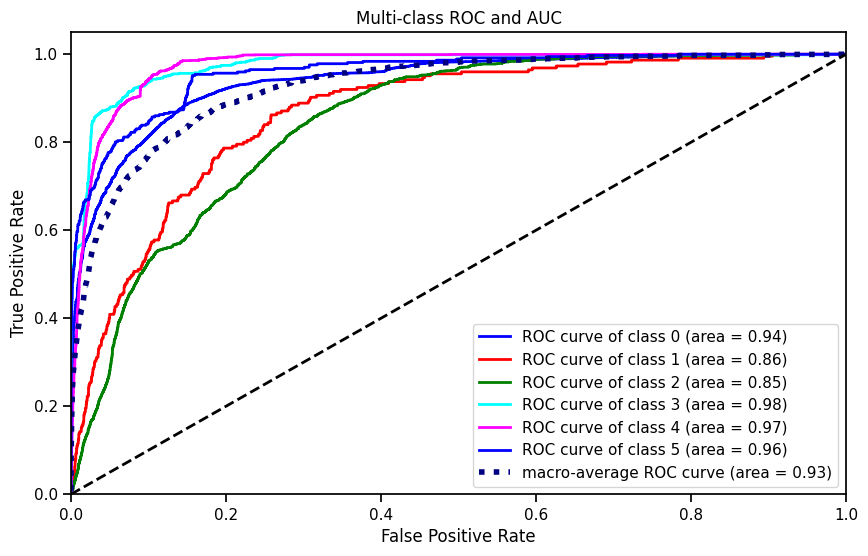

In [103]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

# 计算每个类别的FPR和TPR
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_names)  # 类别的数量

# 计算每个类别的ROC曲线和AUC分数
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid, y_valid_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算宏观平均ROC曲线和AUC分数
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 绘制所有类别的ROC曲线
plt.figure(figsize=(10, 6))
colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

# 绘制宏观平均ROC曲线
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

# 绘制对角线
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC and AUC')
plt.legend(loc="lower right")
plt.show()
